In [9]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Define the path to your dataset folders
base_dir = r'C:\Users\ASUS\OneDrive\Desktop\fyp2\datasets\apple_disease_classification'
train_dir = os.path.join(base_dir, 'Train_Split')
val_dir = os.path.join(base_dir, 'Validation_Split')
test_dir = os.path.join(base_dir, 'Test')

# Ensure consistent target size for the model and data generators
TARGET_SIZE = (224, 224)

# Centralized augmentation settings
def create_datagen(rescale=1./255, augment=False):
    if augment:
        return ImageDataGenerator(
            rescale=rescale,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],  # Adjust brightness
            shear_range=0.2              # Add shear transformation
        )
    return ImageDataGenerator(rescale=rescale)

# Data Augmentation and Image Preprocessing
train_datagen = create_datagen(augment=True)
val_datagen = create_datagen()
test_datagen = create_datagen()

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,  # Updated target size
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=TARGET_SIZE,  # Updated target size
    batch_size=32,
    class_mode='categorical'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,  # Updated target size
    batch_size=32,
    class_mode='categorical'
)

# Compute class weights to handle imbalance
actual_class_distribution = {class_name: count for class_name, count in zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes))}
print(f"Class Distribution in Training Data: {actual_class_distribution}")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

print(f"Class Indices: {train_generator.class_indices}")
class_weights = dict(enumerate(class_weights))
print(f"Computed Class Weights: {class_weights}")

# Callbacks for training
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=30,  # Increased patience to allow more training before stopping
    restore_best_weights=True,
    verbose=1
)

# Ensure the 'models' directory exists
model_dir = r'C:\Users\ASUS\OneDrive\Desktop\fyp2\models'
os.makedirs(model_dir, exist_ok=True)

# Configure the ModelCheckpoint to save in the 'models' directory
model_checkpoint = ModelCheckpoint(
    os.path.join(model_dir, 'final_model_v3.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by factor of 5
    patience=30,  # Increased patience to avoid premature reductions
    min_lr=1e-7,
    verbose=1
)

# Build the CNN Model using transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Updated input shape
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),  # Reduced dense layer size
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 output classes
])

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Found 1280 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Class Distribution in Training Data: {'Blotch_Apple': np.int64(320), 'Normal_Apple': np.int64(320), 'Rot_Apple': np.int64(320), 'Scab_Apple': np.int64(320)}
Class Indices: {'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}
Computed Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


Epoch 1/50


C:\Users\ASUS\fyp\django-lms\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\ASUS\fyp\django-lms\venv\Lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2781 - loss: 2.0547
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to C:\Users\ASUS\OneDrive\Desktop\fyp2\models\final_model_v3.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.2800 - loss: 2.0471 - val_accuracy: 0.6250 - val_loss: 1.0181 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5477 - loss: 1.1128
Epoch 2: val_accuracy improved from 0.62500 to 0.73438, saving model to C:\Users\ASUS\OneDrive\Desktop\fyp2\models\final_model_v3.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5490 - loss: 1.1107 - val_accuracy: 0.7344 - val_loss: 0.7600 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7104 - loss: 0.7860
Epoch 3: val_accuracy improved from 0.73438 to 0.78125, saving model to C:\Users\ASUS\OneDrive\Desktop\fyp2\models\final_model_v3.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7106 - loss: 0.785

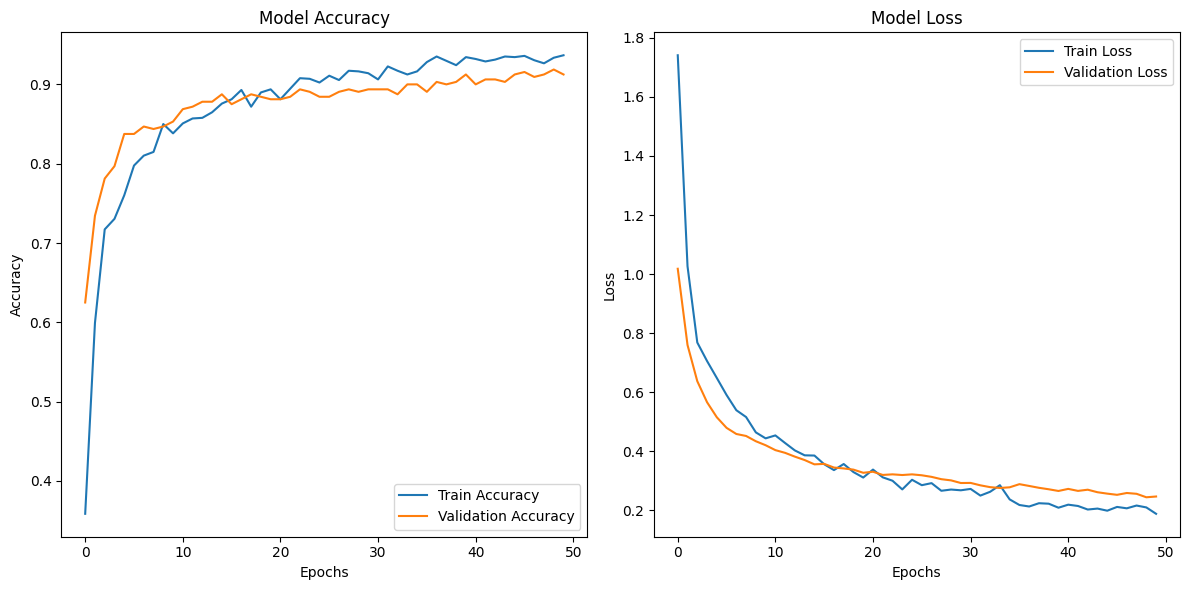

Training and validation metrics plot saved to C:\Users\ASUS\OneDrive\Desktop\fyp2\models\training_validation_metrics_v3.png
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 832ms/step - accuracy: 0.9385 - loss: 0.2297
Test Loss: 0.1962253600358963
Test Accuracy: 0.949999988079071
Average Training Accuracy: 87.24%
Average Validation Accuracy: 87.53%
Average Training Loss: 0.3713
Average Validation Loss: 0.3577
Highest Training Accuracy: 93.67%
Lowest Training Accuracy: 35.86%
Highest Validation Accuracy: 91.87%
Lowest Validation Accuracy: 62.50%


In [35]:
# Train the Model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights
)

# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Save the plot for tracking performance in the 'models' folder
plot_path = os.path.join(model_dir, 'training_validation_metrics_v3.png')
plt.tight_layout()
plt.savefig(plot_path)
plt.show()
print(f"Training and validation metrics plot saved to {plot_path}")

# Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Extract metrics from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculate average, highest, and lowest metrics
avg_train_acc = np.mean(train_acc) * 100
avg_val_acc = np.mean(val_acc) * 100
avg_train_loss = np.mean(train_loss)
avg_val_loss = np.mean(val_loss)

highest_train_acc = np.max(train_acc) * 100
lowest_train_acc = np.min(train_acc) * 100
highest_val_acc = np.max(val_acc) * 100
lowest_val_acc = np.min(val_acc) * 100

# Display the results
print(f"Average Training Accuracy: {avg_train_acc:.2f}%")
print(f"Average Validation Accuracy: {avg_val_acc:.2f}%")
print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Highest Training Accuracy: {highest_train_acc:.2f}%")
print(f"Lowest Training Accuracy: {lowest_train_acc:.2f}%")
print(f"Highest Validation Accuracy: {highest_val_acc:.2f}%")
print(f"Lowest Validation Accuracy: {lowest_val_acc:.2f}%")


In [37]:
model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_16          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,752,462 (10.50 MB)

 Trainable params: 164,740 (643.52 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

 Optimizer params: 329,482 (1.26 MB)

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import sys
print("Python executable:", sys.executable)


TensorFlow version: 2.18.0
Python executable: C:\Users\ASUS\OneDrive\Desktop\fyp2\venv\Scripts\python.exe


In [4]:
import numpy as np
from tensorflow.keras.models import load_model

# Path to your saved model
model_path = r'C:\Users\ASUS\OneDrive\Desktop\fyp2\models\final_model_v3.keras'

# Load the model
try:
    model = load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Verify the model structure
model.summary()

# Create a dummy input with the same input shape as the model expects (224, 224, 3)
dummy_input = np.random.rand(1, 224, 224, 3).astype('float32')  # Batch size of 1

# Test the model on the dummy input
try:
    predictions = model.predict(dummy_input)
    print("Model ran successfully.")
    print(f"Predictions: {predictions}")
except Exception as e:
    print(f"Error during model prediction: {e}")


Model loaded successfully.


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_16          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,752,462 (10.50 MB)

 Trainable params: 164,740 (643.52 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

 Optimizer params: 329,482 (1.26 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Model ran successfully.
Predictions: [[0.6622253  0.00618018 0.03637911 0.29521543]]


C:\Users\ASUS\OneDrive\Desktop\fyp2\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 611ms/step


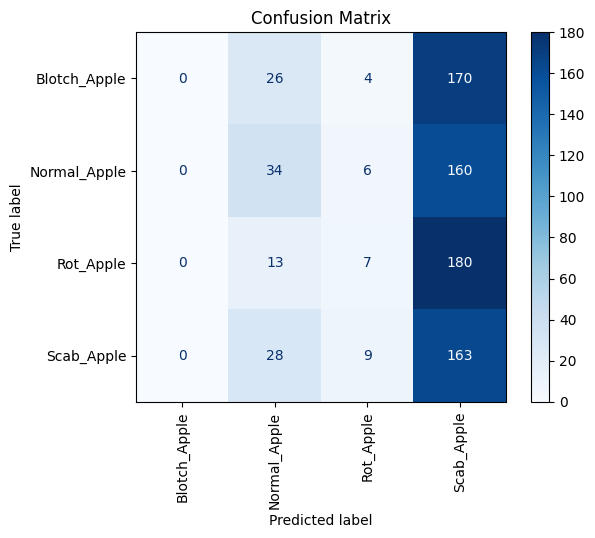

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate predictions and true labels
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = test_generator.classes  # True labels from the test generator

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=test_generator.class_indices.keys())
cmd.plot(cmap='Blues', xticks_rotation='vertical')
cmd.ax_.set_title("Confusion Matrix")
plt.show()


In [11]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

Blotch_Apple       0.00      0.00      0.00       200
Normal_Apple       0.34      0.17      0.23       200
   Rot_Apple       0.27      0.04      0.06       200
  Scab_Apple       0.24      0.81      0.37       200

    accuracy                           0.26       800
   macro avg       0.21      0.26      0.17       800
weighted avg       0.21      0.26      0.17       800



C:\Users\ASUS\OneDrive\Desktop\fyp2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\OneDrive\Desktop\fyp2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\OneDrive\Desktop\fyp2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

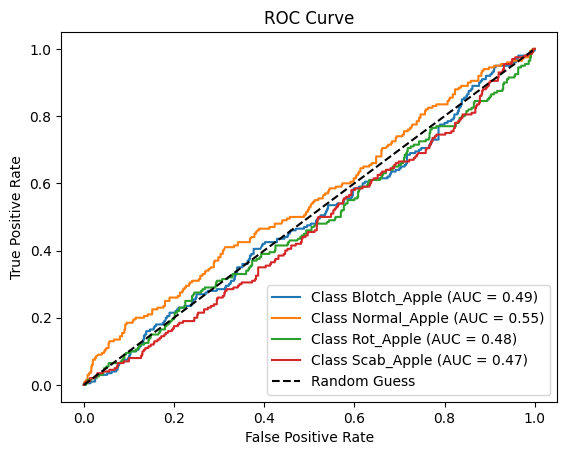

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(len(test_generator.class_indices)))
n_classes = y_true_binarized.shape[1]

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [13]:
class_accuracies = {}
for class_label, class_index in test_generator.class_indices.items():
    correct_preds = sum((y_pred_classes == class_index) & (y_true == class_index))
    total_class_samples = sum(y_true == class_index)
    class_accuracies[class_label] = correct_preds / total_class_samples

print("Per-Class Accuracy:")
for class_label, acc in class_accuracies.items():
    print(f"{class_label}: {acc:.2%}")


Per-Class Accuracy:
Blotch_Apple: 0.00%
Normal_Apple: 17.00%
Rot_Apple: 3.50%
Scab_Apple: 81.50%
